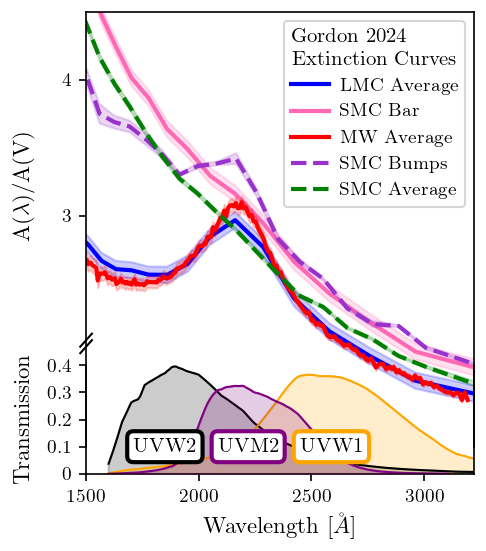

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import astropy.units as u
from matplotlib.patches import Rectangle
from matplotlib import rcParams
import os 

data_dir = os.getenv("DATADIR")
plt.style.use(data_dir+'bl.mplstyle')
rcParams["mathtext.fontset"] = 'cm'
dir = data_dir+'4_MagellanicClouds/Extinction/'

# Interpolate extinction curve 
def get_interpolated_gordon_function(gordon_file):
    # x [um^-1], A(lambda)/A(V), unc # unc = uncertainty
    gordon = pd.read_csv(gordon_file,skiprows=7,delimiter=' ',names=['wavelength','extinction','error'])
    wav = (np.array(1 / gordon["wavelength"]) * u.micron).to(u.Angstrom)
    ext = gordon["extinction"]
    err = gordon["error"]
    interp_wav = np.arange(1500, 10000, 0.1)
    func = interpolate.interp1d(wav.value, ext)
    interp_ext = func(interp_wav)
    func_err = interpolate.interp1d(wav.value, err)
    interp_err = func_err(interp_wav)
    # Save all as df
    df = pd.DataFrame({"wavelength": interp_wav, "extinction": interp_ext, "error": interp_err})
    return df
def get_interpolated_gordon_function2(gordon_file,Rv =2.05440):
    # x [um^-1], E(lambda-V)/E(B-V), unc
    gordon = pd.read_csv(gordon_file,skiprows=7,delimiter=' ',names=['wavelength','extinction','error'])
    wav = (np.array(1 / gordon["wavelength"]) * u.micron).to(u.Angstrom)
    # Convert to A(lambda)/A(V)
    ext = (gordon["extinction"]/Rv) + 1
    err = gordon["error"]
    interp_wav = np.arange(1500, 10000, 0.1)
    func = interpolate.interp1d(wav.value, ext)
    interp_ext = func(interp_wav)
    func_err = interpolate.interp1d(wav.value, err)
    interp_err = func_err(interp_wav)
    # Save all as df
    df = pd.DataFrame({"wavelength": interp_wav, "extinction": interp_ext, "error": interp_err})
    return df
def get_interpolated_pei_function(pei_file):
    pei = pd.read_csv(pei_file)
    pei['Wavelength'] = (1/pei['Wavelength'].to_numpy()* u.micron).to(u.Angstrom).value
    pei_wv = np.arange(1500, 10000, 0.1)
    func = interpolate.interp1d(pei['Wavelength'] , pei['Extinction'] )
    pei_ext = func(pei_wv)
    Rv = 2.93
    pei_ext = (pei_ext/Rv) + 1
    return pei_wv, pei_ext

# UV Filters 
w2 = pd.read_csv(dir+'Filters/Swift_UVOT.UVW2_trn.dat',delimiter=" ",names=['wavelength','transmission'])
w1 = pd.read_csv(dir+'Filters/Swift_UVOT.UVW1_trn.dat',delimiter=" ",names=['wavelength','transmission'])
m2 = pd.read_csv(dir+'Filters/Swift_UVOT.UVM2_trn.dat',delimiter=" ",names=['wavelength','transmission'])

# Plotting
f = plt.figure(constrained_layout=False,  figsize=(3.34,4.),dpi=150)
hspace = -.3
gs1 = f.add_gridspec(nrows=2, ncols=1, hspace=hspace, wspace=0.1, height_ratios=[1,0.25])
ax = f.add_subplot(gs1[0])
bx = f.add_subplot(gs1[1])

lw = 2
colors = ['blue','red','hotpink','green','darkorchid']


# Milky Way Average
from dust_extinction.averages import (GCC09_MWAvg,B92_MWAvg,G03_SMCBar,G03_LMCAvg,
                                       G03_LMC2,G24_SMCAvg,G24_SMCBumps)
# Get Model
ext_model = GCC09_MWAvg()

# WITH ERROR BARS 
# LMC AVG 03
ext_model = G03_LMCAvg()
wv = (1/ext_model.obsdata_x*u.micron).to(u.Angstrom).value
ind = np.where((wv > 1200) & (wv < 4000))
wv = wv[ind]
ext = ext_model.obsdata_axav[ind]
err = 6e-2 # obsdata tolerance from source code
ax.plot(wv,ext,label='LMC Average',color='blue',lw=lw,zorder=0,ls='-')
ax.fill_between(wv,ext-err,ext+err,color='blue',alpha=0.2,zorder=0)

# SMC Bar 03
ext_model = G03_SMCBar()
wv = (1/ext_model.obsdata_x*u.micron).to(u.Angstrom).value
ind = np.where((wv > 1200) & (wv < 4000))
wv = wv[ind]
ext = ext_model.obsdata_axav[ind]
err = 6e-2 # obsdata tolerance from source code
ax.plot(wv,ext,label='SMC Bar',color='hotpink',lw=lw,zorder=0,ls='-')
ax.fill_between(wv,ext-err,ext+err,color='hotpink',alpha=0.2,zorder=0)

# MW 2009
ext_model = GCC09_MWAvg()
wv = (1/ext_model.obsdata_x_iue*u.micron).to(u.Angstrom).value
ind = np.where((wv > 1200) & (wv < 4000))
wv = wv[ind]
ext = ext_model.obsdata_axav_iue[ind]
err = ext_model.obsdata_axav_unc_iue[ind]
# remove couple outliers
ind = np.where((wv < 1600) & (ext > 2.7)) 
wv = np.delete(wv,ind)
ext = np.delete(ext,ind)
err = np.delete(err,ind)
ax.plot(wv,ext,label='MW Average',color='r',lw=lw,zorder=0,ls='-')
ax.fill_between(wv,ext-err,ext+err,color='r',alpha=0.2,zorder=0)

# SMC BUMPS 2024 
ext_model = G24_SMCBumps()
wv = (1/ext_model.obsdata_x*u.micron).to(u.Angstrom).value
ind = np.where((wv > 1200) & (wv < 4000))
wv = wv[ind]
ext = ext_model.obsdata_axav[ind]
err = ext_model.obsdata_axav_unc[ind]
ax.plot(wv,ext,label='SMC Bumps',color='darkorchid',lw=lw,zorder=0,ls='--')
ax.fill_between(wv,ext-err,ext+err,color='darkorchid',alpha=0.2,zorder=0)

# SMC Average 2024 
ext_model = G24_SMCAvg()
wv = (1/ext_model.obsdata_x*u.micron).to(u.Angstrom).value
ind = np.where((wv > 1200) & (wv < 4000))
wv = wv[ind]
ext = ext_model.obsdata_axav[ind]
err = ext_model.obsdata_axav_unc[ind]
ax.plot(wv,ext,label='SMC Average',color='green',lw=lw,zorder=0,ls='--')
ax.fill_between(wv,ext-err,ext+err,color='green',alpha=0.2,zorder=0)

bx.plot(w2['wavelength'],w2['transmission'],label='Swift UVOT W2',color='black')
bx.plot(w1['wavelength'],w1['transmission'],label='Swift UVOT W1',color='orange')
bx.plot(m2['wavelength'],m2['transmission'],label='Swift UVOT M2',color='purple')

# Fill between transmission and bottom of plot 
bx.fill_between(w2['wavelength'],w2['transmission'],color='black',alpha=0.2)
bx.fill_between(w1['wavelength'],w1['transmission'],color='orange',alpha=0.2)
bx.fill_between(m2['wavelength'],m2['transmission'],color='purple',alpha=0.2,zorder=10)

# Make box to label UV filters
y = .10
fs = 12
bx.text(1850, y, 'UVW2', ha="center", va="center", size=fs-2, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2),zorder=10)
bx.text(2220, y, 'UVM2', ha="center", va="center", size=fs-2, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="purple", lw=2),zorder=10)
bx.text(2590, y, 'UVW1', ha="center", va="center", size=fs-2, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="orange", lw=2),zorder=10)

# Add two diagonal lines over the axes 
d = .015
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False,lw=1)
y = 0.23
ax.plot((-d, +d), (y-d, y+d), **kwargs)
ax.plot((-d, +d), (y-d+d, y+d+d), **kwargs)

##########
# LEGEND #
##########
handles, labels = ax.get_legend_handles_labels()

leg = ax.legend(title="   Gordon 2024\nExtinction Curves",facecolor='none',loc='upper right',bbox_to_anchor=(1.0, 1.0),handlelength=2,handletextpad=0.6)
leg._legend_box.align = "center"
n = -300


##########
#  AXIS  #
##########
[axx.set_xlim(1500,3225) for axx in [ax,bx]]
ax.set_ylabel(r'A($\lambda$)/A(V)',labelpad=13,y=.6)
bx.set_ylabel('Transmission',y=.5,labelpad=6)
bx.set_xlabel(r'Wavelength [$\AA$]')
bx.patch.set_alpha(0)
# Sex yticks top plot 
ax.set_ylim(1.3,4.5)
ax.set_yticks([3,4])
ax.set_yticklabels(['3','4'])
# Sex yticks bottom plot 
bx.set_ylim(0,0.4)
bx.set_yticks([0,0.1,0.2,0.3,0.4])
bx.set_yticklabels(['0','0.1','0.2','0.3','0.4'])
# Remove spine
ax.spines['bottom'].set_visible(False)
bx.spines['top'].set_visible(False)
# Remove x axis from top plot
ax.xaxis.set_visible(False)

# Save 
plt.savefig('ExtinctionCurveWithRef.pdf',bbox_inches='tight',dpi=1000)